## Exploratory Data Analysis (EDA) 


In [2]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
df = pd.read_csv('train_df.csv')

In [4]:
df.shape

(5798, 26)

In [5]:
df.drop(columns=['index'], inplace=True)

## Let's start exploring some hypothesis
We start from the research question: **Is there a time of day, or a period that is less relevant to the weather?**
-   H₁:Bad weather conditions generally lead to a marked reduction in bike rentals. 
-	H₂: Higher temperatures lead to an increase in bike rentals.
-	H₃: Lendings during rush hours (e.g., 7–9 AM and 4–6 PM) are less affected by weather due to commuting necessity.
-	H₅: Weekend rentals are more sensitive to weather conditions compared to weekday rentals.

In [6]:
# Define bin edges based on the quartiles and maximum
bin_edges = [0, 7, 11, 16, float('inf')]
bin_labels = ['Calm', 'Moderate', 'Breezy', 'Windy']

# Create a new column for wind speed bins
df['windspeed_bin'] = pd.cut(df['windspeed_kph'], bins=bin_edges, labels=bin_labels, right=False)
df['windspeed_bin'] = pd.Categorical(df['windspeed_bin'], categories=bin_labels, ordered=True)


In [7]:
windspeed_dummies = pd.get_dummies(df['windspeed_bin'], prefix='windspeed', drop_first=True)
df = pd.concat([df, windspeed_dummies], axis=1) 

In [8]:
df.groupby('bad_weather')['trip_count'].mean()

bad_weather
0    24.355439
1     9.380655
Name: trip_count, dtype: float64

In [9]:
df.groupby('temperature_bin')['trip_count'].mean()

temperature_bin
Cold         11.626506
Hot          90.795620
Mild         25.692629
Very Cold     6.959302
Warm         47.357337
Name: trip_count, dtype: float64

C:\Users\gsant\AppData\Local\Temp\ipykernel_11304\474414059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='trip_count', y='wind_chill_bin', data=df, palette='dark')


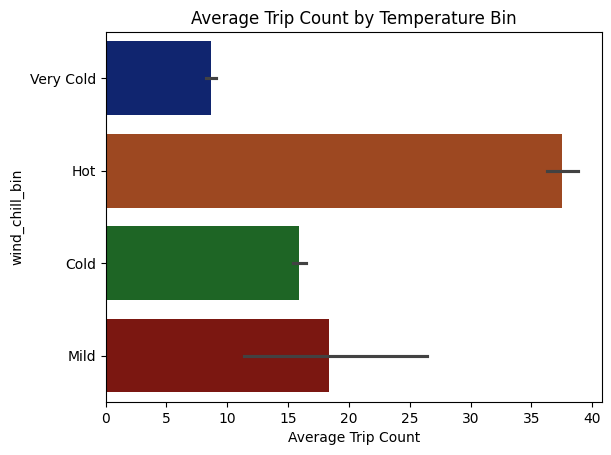

In [10]:
sns.barplot(x='trip_count', y='wind_chill_bin', data=df, palette='dark')  
plt.title('Average Trip Count by Temperature Bin')
plt.xlabel('Average Trip Count')    
plt.show()

In [11]:
df['trip_count'].describe()

count    5798.000000
mean       22.699897
std        26.175480
min         0.000000
25%         5.000000
50%        14.000000
75%        30.000000
max       187.000000
Name: trip_count, dtype: float64

In [12]:
df[df['trip_count'].between(0,3)].groupby('time_of_day').size() #trip count between 0 and 3

time_of_day
Afternoon     20
Evening       23
LateNight    604
Morning      437
Night         95
dtype: int64

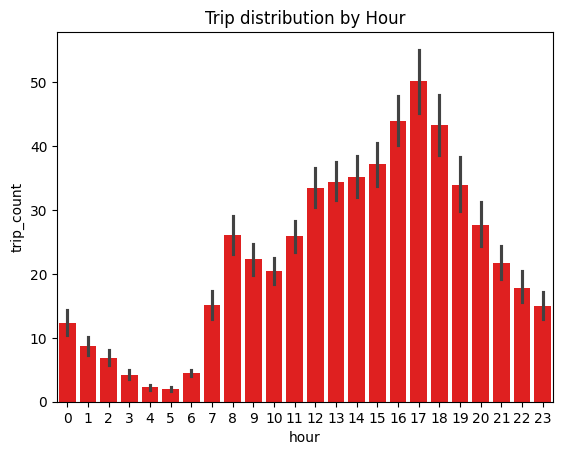

In [13]:
sns.barplot(y='trip_count', x='hour', data=df, color='red')
plt.title('Trip distribution by Hour')
plt.show()

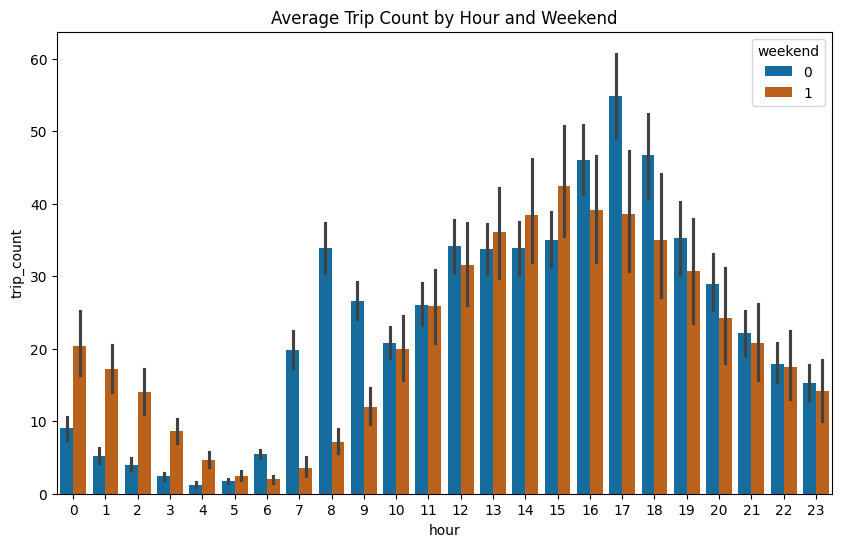

In [14]:
colors = ["#0072B2", "#D55E00"]

plt.figure(figsize=(10, 6))
sns.barplot(y='trip_count', x='hour', data=df, palette = colors, hue='weekend')
plt.title('Average Trip Count by Hour and Weekend')
plt.show()

Here I identified the rush hours. As one could notice, the blue bars are significantly higher during the 'Morning Rush' hours (7–9 AM) and 'Afternoon Rush' hours (4–6 PM). 

Additionally, in non-peak hours, the average trip count is proportionally higher on weekends compared to weekdays, particularly during late-night hours (midnight to 5 AM) and early afternoon hours (1–3 PM). 

Based on these observations, I can redefine the 'time of day bin' to better capture these intervals.
Since my starting hypothesis was that people that are commuting to work/university/school should be less sensitive and also more organized to hendle bad weather and cold temperatures, as they use bikes abitually.

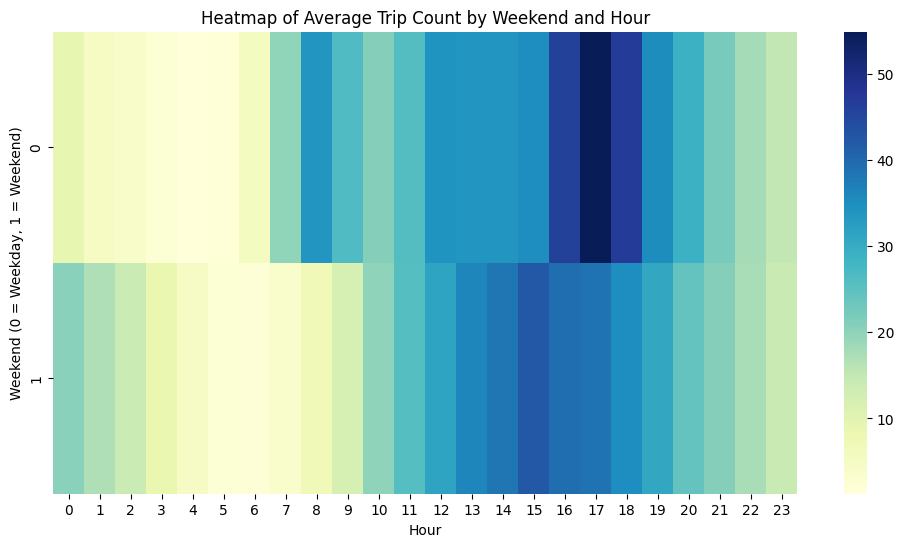

In [15]:
# Calculate the mean trip_count grouped by weekend and hour
heatmap_data = df.groupby(['weekend', 'hour'])['trip_count'].mean().unstack()

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Average Trip Count by Weekend and Hour')
plt.xlabel('Hour')
plt.ylabel('Weekend (0 = Weekday, 1 = Weekend)')
plt.show()

As shown from this heathmap, In working days there is lower overnight usage (10 PM–5 AM) too: Usage tapers off significantly late at night and early morning.
in weekends we have broader Midday to Early Evening Activity (10 AM–6 PM): The heatmap is relatively darker in these hours, suggesting higher average trip counts over a wider midday window.
Also slightly higher usage may occur in late-night hours.

Overall, the highest average trip counts occur on weekdays in the late afternoon commute window, and on weekends in the midday to early evening. 

In [16]:
def time_of_day(hour):
    '''Segments the hour into different times of the day
       Morning: 6-12, Afternoon: 12-17, Evening: 17-21, Night: 21-5'''
    if 6 <= hour < 9:
        return 'Morning Rush Hour'   
    if 9 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Early Afternoon'
    elif 16 <= hour < 18:
        return 'Afternoon Rush Hour'
    elif 18 <= hour < 21:
        return 'Evening'
    elif 21 <= hour < 24:
        return 'Night'
    else:
        return 'Late Night'

df['time_of_day'] = df['hour'].apply(time_of_day)
df['time_of_day'].value_counts(normalize=True) #value counts of time segments

time_of_day
Late Night             0.249569
Early Afternoon        0.166954
Morning Rush Hour      0.125216
Night                  0.125216
Morning                0.125043
Evening                0.124698
Afternoon Rush Hour    0.083305
Name: proportion, dtype: float64

C:\Users\gsant\AppData\Local\Temp\ipykernel_11304\2197223644.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='trip_count', y='time_of_day', data=df, palette='dark')


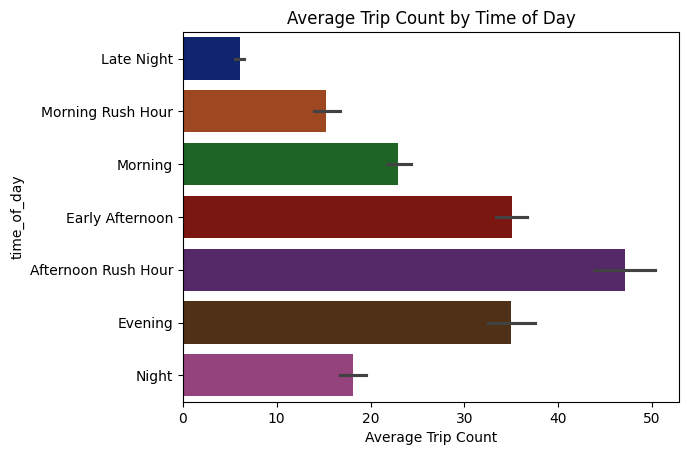

In [17]:
sns.barplot(x='trip_count', y='time_of_day', data=df, palette='dark')
plt.title('Average Trip Count by Time of Day')
plt.xlabel('Average Trip Count')
plt.show()

- **Afternoon Rush Hour** has the highest average trip count, surpassing **40 trips** on average.
- **Evening** and **Early Afternoon** also see elevated usage, though slightly lower than the afternoon rush.
- **Morning Rush Hour** and **Morning** have moderate counts, reflecting commuting patterns.
- **Night** and **Late Night** show the lowest ridership, likely due to fewer people traveling during those hours.

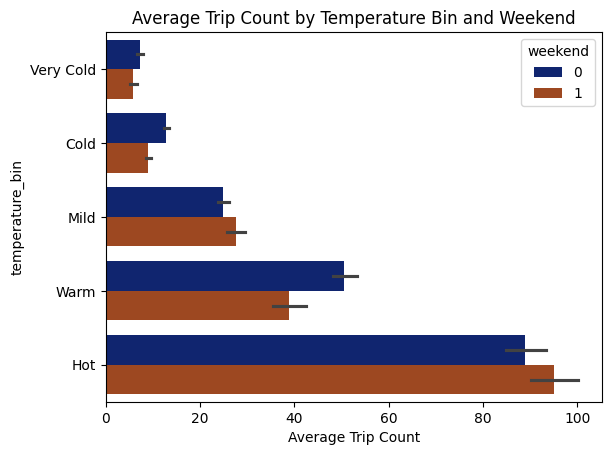

In [18]:
sns.barplot(x='trip_count', y='temperature_bin', data=df, palette='dark', hue='weekend')
plt.title('Average Trip Count by Temperature Bin and Weekend')
plt.xlabel('Average Trip Count')
plt.show()

- Across all temperature bins, weekdays (blue) generally show higher average trip counts than weekends (brown).
- **Hot** conditions yield the highest average counts overall, with weekday usage peaking near 100 trips.
- **Very Cold** conditions show the lowest average counts for both weekdays and weekends.
- These patterns suggest that riders prefer biking in **warmer** weather, and weekday demand remains higher than weekend demand across temperature bins.

In [19]:
df.groupby('temperature_bin')['trip_count'].sum()

temperature_bin
Cold         28950.0
Hot          24878.0
Mild         36946.0
Very Cold     5985.0
Warm         34855.0
Name: trip_count, dtype: float64

In [20]:
# Create a new DataFrame for working days
weekady_df = df[df['weekend'] == 0] # Filter out the weekends for the weekday_df
weekady_df['rush_hour'] = weekady_df['time_of_day'].isin(['Morning Rush Hour', 'Afternoon Rush Hour']).astype(int) # Create a binary variable for rush hour

C:\Users\gsant\AppData\Local\Temp\ipykernel_11304\2080630646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekady_df['rush_hour'] = weekady_df['time_of_day'].isin(['Morning Rush Hour', 'Afternoon Rush Hour']).astype(int) # Create a binary variable for rush hour


In [21]:
# New DataFrame for the morning and afternoon rush hours in weekdays
rush_weekday_df = df[df['time_of_day'].isin(['Morning Rush Hour', 'Afternoon Rush Hour']) & (df['weekend'] == 0)] # Filter out the weekends for the rush_df 
no_rush_weekday_df = df[~df['time_of_day'].isin(['Morning Rush Hour', 'Afternoon Rush Hour']) & (df['weekend'] == 0)] # Filter out the rush hours for the no_rush_df 

In [23]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Fit an OLS model using the categorical humidity_bin variable.
# The C() function tells statsmodels to treat the variable as categorical.
model = smf.ols('trip_count ~ C(humidity_bin)', data=weekady_df).fit()

# Perform the ANOVA test.
anova_results = anova_lm(model)
print(anova_results)

                     df        sum_sq        mean_sq           F  PR(>F)
C(humidity_bin)     3.0  1.051501e+06  350500.269611  787.995847     0.0
Residual         4116.0  1.830795e+06     444.799641         NaN     NaN


  - The **p-value (PR(>F) = 0.0)** is reported as 0.0 (which means it is very close to zero), suggesting that the difference in means across humidity bins is statistically significant at any conventional significance level.
  ### Conclusion

The results provide strong evidence that the mean trip counts differ significantly across the humidity bins. This indicates that humidity (when categorized into bins) has a statistically significant effect on trip counts. 

Given the high F-statistic and the p-value of essentially 0, you can conclude that at least one of the humidity bins has a mean trip count that is significantly different from the others.

This supports the notion that humidity levels (as binned) play an important role in influencing trip counts.

**Post-Hoc Anova**

In [24]:
# Post-hoc ANOVA
# Import Tukey's HSD function
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_oneway = pairwise_tukeyhsd(endog=weekady_df['trip_count'], groups=weekady_df['humidity_bin'], alpha=0.05)
print(tukey_oneway)  # Print the results of Tukey's test

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2  meandiff p-adj  lower    upper   reject
----------------------------------------------------------
    High       Low  39.5657   0.0  37.0718  42.0597   True
    High  Moderate  12.2035   0.0   9.8154  14.5917   True
    High Very High  -3.0482 0.003  -5.3104   -0.786   True
     Low  Moderate -27.3622   0.0 -29.9141 -24.8102   True
     Low Very High -42.6139   0.0 -45.0484 -40.1795   True
Moderate Very High -15.2517   0.0 -17.5777 -12.9258   True
----------------------------------------------------------


### Pairwise Comparison Interpretation

- **Group1 vs. Group2**: The two groups being compared (e.g., different humidity bins).  
- **Mean Difference (meandiff)**: The difference between the average (mean) responses of Group1 and Group2.  
    - A **positive number** means Group1 has a higher mean than Group2.  
    - A **negative number** means Group1 has a lower mean than Group2.  

---

#### Example Interpretations:

1. **High vs. Low**:  
     - On average, the **High humidity bin** has about **38 more trips** than the **Low humidity bin**.  
     - Since the confidence interval (CI) does not include 0 and the p-adj value is very small, the difference is **highly significant**.

2. **High vs. Moderate**:  
     - The **High humidity bin** exceeds the **Moderate humidity bin** by approximately **10 trips** on average.

3. **High vs. Very High**:  
     - The **High humidity bin** has about **3 fewer trips** than the **Very High humidity bin**.  
     - The negative difference indicates that **Low** has a **lower mean trip count** than **Very High**.



## H₁: Rush Hour Rentals Less Affected by Weather
- Lendings during rush hours (e.g., 6–9 AM and 4–6 PM) are less affected by weather due to commuting necessity.

**Mean trip count comparison**

In [25]:
# Mean trip count comparison
print("Rush hour - Bad weather:", round(rush_weekday_df[rush_weekday_df['bad_weather'] == 1]['trip_count'].mean(), 2))
print("Rush hour - Good weather:", round(rush_weekday_df[rush_weekday_df['bad_weather'] == 0]['trip_count'].mean(), 2)) 
print("No rush hour - Bad weather:", round(no_rush_weekday_df[no_rush_weekday_df['bad_weather'] == 1]['trip_count'].mean(), 2))
print("No rush hour - Good weather:", round(no_rush_weekday_df[no_rush_weekday_df['bad_weather'] == 0]['trip_count'].mean(), 2))

Rush hour - Bad weather: 16.11
Rush hour - Good weather: 34.08
No rush hour - Bad weather: 9.36
No rush hour - Good weather: 22.37


**Interpretation of Average Trip Count by Rush Hour and Weather conditions in Working Days**

- **Rush Hour + Good Weather**: 34.08 trips, indicating the highest average usage during commutes in favorable conditions.  
- **Rush Hour + Bad Weather**: 16.11 trips, still higher than non-rush hours, but reduced due to poor conditions.  
- **Non-Rush Hour + Good Weather**: 22.37 trips, reflecting moderate midday or evening usage when the weather is pleasant.  
- **Non-Rush Hour + Bad Weather**: 9.36 trips, the lowest average ridership on workdays.  

Overall, **weather and commuting windows** are key factors driving bike usage on weekdays.

In [26]:
# Select only numeric columns for correlation calculation
numeric_columns = weekady_df.select_dtypes(include=['number'])

# Calculate correlation coefficients
correlation_matrix = numeric_columns.corr()

# Extract correlations with 'trip_count'
trip_count_correlations = correlation_matrix['trip_count'].sort_values(ascending=False)

# Display the correlations
print(trip_count_correlations)

trip_count               1.000000
temperature_C            0.715890
month                    0.520485
hour                     0.360544
visibility_km            0.338147
wind_chill_C             0.338100
windspeed_kph            0.185819
rush_hour                0.167770
wind_direction_degres    0.103026
thunder                  0.001689
pressure_mBar           -0.061785
fog                     -0.074561
severe_weather          -0.086196
snow                    -0.088178
rain                    -0.140134
bad_weather             -0.159501
humidity                -0.596819
weekend                       NaN
Name: trip_count, dtype: float64


**Key Correlations with `trip_count`**

- **`temperature_C` (r ≈ 0.72)**  
  Strong positive correlation, indicating that higher temperatures coincide with more trips.  

- **`month` (r ≈ 0.52)**  
  Moderate positive association suggests seasonal patterns—trip counts tend to rise in later (warmer) months.
- **`humidity` (r ≈ –0.60)**  
  Notable negative relationship: as humidity climbs, trip counts fall, implying less comfort or desirability to ride.

### Testing Model Assumptions

**Linearity Assumption**

<Figure size 1500x1000 with 0 Axes>

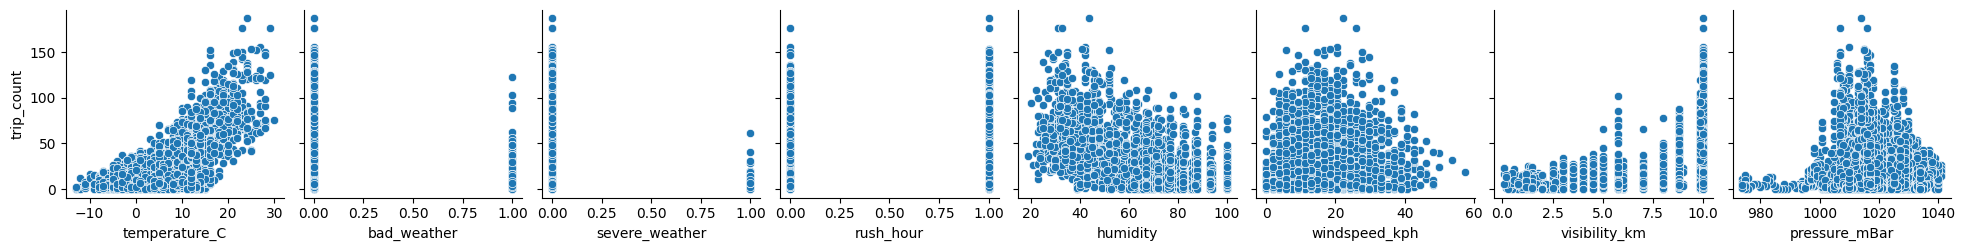

In [27]:
plt.figure(figsize=(15, 10))
sns.pairplot(weekady_df, x_vars=['temperature_C', 'bad_weather', 'severe_weather', 'rush_hour', 'humidity', 'windspeed_kph', 'visibility_km', 'pressure_mBar'], y_vars='trip_count')
plt.show() # Pairplot of the features against trip_count


Text(0.5, 1.0, 'Temperature vs Trip Count')

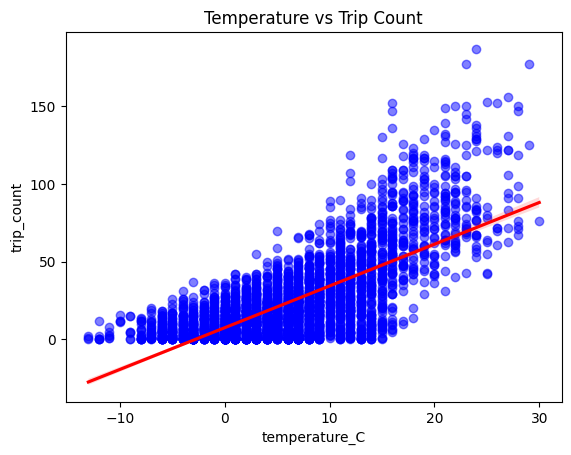

In [28]:
sns.regplot(
    x='temperature_C', 
    y='trip_count', 
    data=weekady_df, 
    color='blue', 
    marker='o', 
    scatter_kws={'alpha': 0.5}, 
    line_kws={'color': 'red'}  # Change the regression line color to red
)
plt.title('Temperature vs Trip Count')

**Trip Count vs Temperature**

- A **positive linear trend** emerges: as the temperature increases, so does the number of trips.
- The bulk of data points cluster around **mild to warm** temperatures (above 0 °C), aligning with **higher trip counts**.
- Lower temperatures (below 0 °C) show relatively **fewer trips**, suggesting riders favor **warmer** conditions.
- A **dense cluster of near-zero trips** likely corresponds to **night or late-night hours**, when fewer rides occur.

Points generally cluster around the line, but there’s still visible scatter. This suggests that temperature is a strong predictor of trip count but not the only factor. 

Text(0.5, 1.0, 'Humidity vs Trip Count')

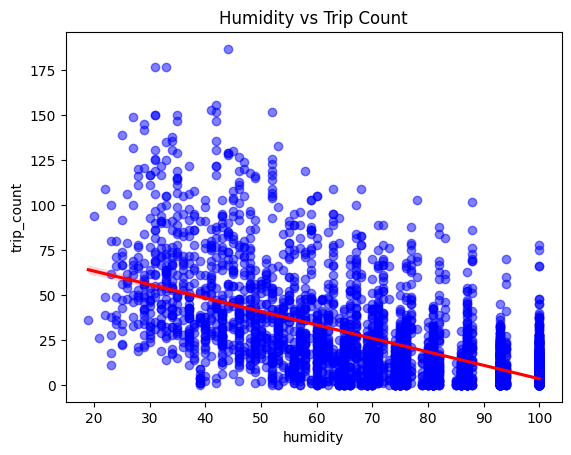

In [29]:
# Create a scatter plot with regression line for humidity
sns.regplot(
    x='humidity', 
    y='trip_count', 
    data=weekady_df, 
    color='blue', 
    marker='o', 
    scatter_kws={'alpha': 0.5}, 
    line_kws={'color': 'red'}  # Change the regression line color to red
)
plt.title('Humidity vs Trip Count')

Despite the downward trend, the scatter points spread widely around the regression line, suggesting there are other factors influencing trip count beyond humidity alone.

**Let's define a weekday dataframe**

In [30]:
weekady_df = df[df['weekend'] == 0] # Filter out the weekends for the weekday_df

In [31]:
weekady_df[windspeed_dummies.columns].dtypes # Sum of the dummies

windspeed_Moderate    bool
windspeed_Breezy      bool
windspeed_Windy       bool
dtype: object

In [32]:
# Create a new column for the lagged trip count (e.g., lag-1)
weekady_df['trip_count_lag1'] = weekady_df['trip_count'].shift(1)

# Drop the first row if it introduces a NaN value due to lagging
weekady_df = weekady_df.dropna(subset=['trip_count_lag1'])


C:\Users\gsant\AppData\Local\Temp\ipykernel_11304\2320624280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekady_df['trip_count_lag1'] = weekady_df['trip_count'].shift(1)


In [62]:
# nteraction in Regression:

weekady_df['rush_hour'] = weekady_df['time_of_day'].isin(['Morning Rush Hour', 'Afternoon Rush Hour']).astype(int) # Create a binary variable for rush hour

X = weekady_df[['temperature_C', 'bad_weather', 'severe_weather', 'rush_hour', 'humidity', 'trip_count_lag1', 'windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy', 'visibility_km', 'pressure_mBar', 'month']].copy() # Independent variables

# Convert boolean columns to integers
X[['windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy']] = X[['windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy']].astype(int)

# Add interaction terms
X['rush_h_bad_w'] = X['rush_hour'] * X['bad_weather'] # interaction term 
X['rush_temp_interaction'] = X['rush_hour'] * X['temperature_C'] # interaction term for temperature and rush hour

y = weekady_df['trip_count'] # dependent variable
X = sm.add_constant(X) # Add a constant term to the predictor variables
OLS = sm.OLS(y, X).fit() # Fit the model with interaction term

print(OLS.summary())

                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     2362.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:28:36   Log-Likelihood:                -14797.
No. Observations:                4119   AIC:                         2.962e+04
Df Residuals:                    4104   BIC:                         2.972e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.61

##  We are testing whether the effect of the weather condition on bike rentals differs between rush hour and non–rush hour periods.
- An interaction term will let us estimate if the magnitude of the weather effect is smaller during rush hours.

***rush_temp_interaction***
**Definition:**  
An interaction term between `rush_hour` (0 or 1) and `temperature_C`.

**Interpretation (β₈):**  
- **Positive β₈:**  
  During rush hours, each additional degree Celsius leads to a greater increase in trip counts than during non-rush hours.
  That result is statistically significant (p value = 0.000), with a coefficient of 0.5, meaning that on average, an increase of 1 Celsius degree in rush hours leads to an increase of almost one trip for half hour compared to non-rush hours.
  - That results goes against our initial hypothesis that rush hours would be less sensitive to weather conditions.

---

### rush_h_bad_w
**Definition:**  
An interaction term between `rush_hour` (0/1) and `bad_weather` (0/1).

**Interpretation (β₉):**  
- **Negative β₉:**  
  Bad weather has an even stronger negative effect on trip counts during rush hour compared to non-rush hours.
- This result is statistically significant ta 99%, with coeafficient of -4.3, in other words, bad weather conditions (rain or fog) lead to a further decrease of roughly 4 trips for half hours on average if compared to non-rush hours.

**- These results as well are apparently going against our hypothesis of rush hours been less affected by weather, however This is an accurate interpretation in absolute terms.**


"Our model indicates that bad weather reduces trip counts more in absolute terms during rush hours than during non-rush hours, as evidenced by the negative interaction term (coefficient = -4.3). However, since the baseline trip counts during rush hours are significantly higher than in non-rush hours, the observed absolute decrease may be partly a consequence of these scale differences. To assess whether bad weather has a relatively stronger impact during rush hours, we need to analyze the percentage change in trip counts.

***Normality of Errors***

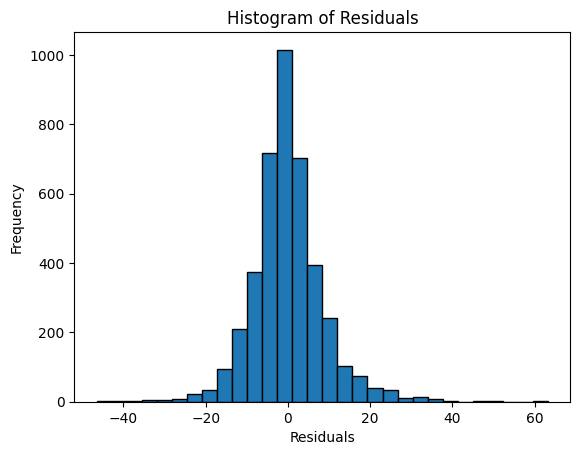

In [34]:
# Histogram of residuals    
plt.hist(OLS.resid, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

- The residuals are **closely centered around zero**, with a fairly **symmetric** shape.
- This suggests that the model makes **no strong systematic errors** in either direction for the majority of observations.
- **Tails appear relatively balanced**, indicating no extreme skewness.
- Combined with a near-zero mean, this histogram reflects a **substantially improved fit** compared to earlier models with more pronounced skewness.

***Multicollinearity***

In [35]:
#calculation of VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
vif = zip(X, vif)
print(list(vif))

[('const', 19410.152309804864), ('temperature_C', 3.028021224063051), ('bad_weather', 1.4984213280170073), ('severe_weather', 1.09753947485586), ('rush_hour', 1.7808131112968757), ('humidity', 3.253507908281623), ('trip_count_lag1', 2.588781180213857), ('windspeed_Moderate', 1.5206555868636824), ('windspeed_Breezy', 1.6792954268619604), ('windspeed_Windy', 2.054414148372378), ('visibility_km', 1.995884492022811), ('pressure_mBar', 1.6954892409423008), ('rush_h_bad_w', 1.4480901488965958), ('rush_temp_interaction', 1.9342352188830103)]


**No high multicollinearity detected**

***Homoskedasticity***

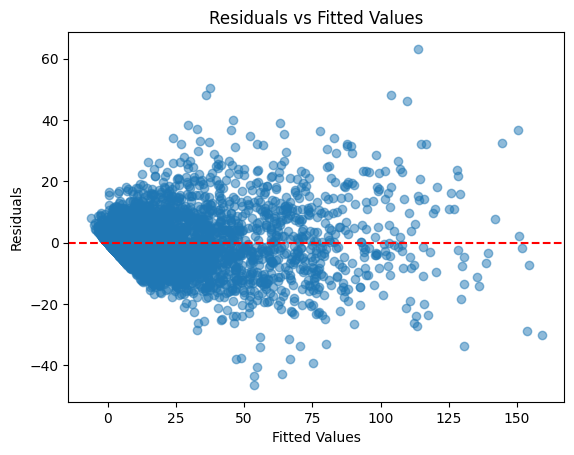

In [36]:
#residuals vs fitted values plot   
plt.scatter(OLS.fittedvalues, OLS.resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

- The residuals scatter evenly around the zero line for most fitted values, indicating **no severe systematic bias**.
- At higher fitted values (above ~100), **some increased spread** suggests slight heteroskedasticity or unmodeled factors.
- Overall, the distribution around zero is tighter than before, **suggesting an improved model fit** with fewer systematic errors

***Q-Q Plot***

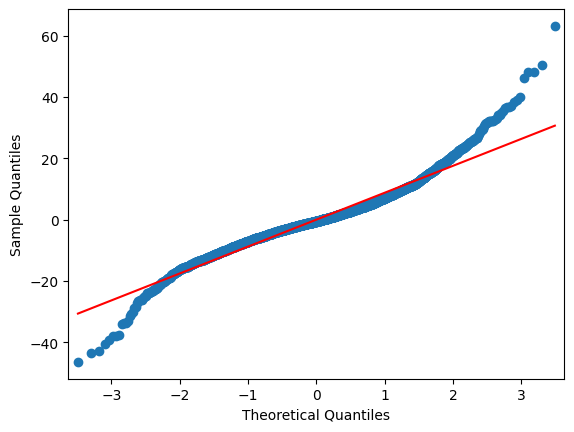

In [37]:
# Q-Q plot
sm.qqplot(OLS.resid, line='s')
plt.show()

- The points **align more closely** with the red diagonal than earlier, suggesting **improved normality** in the residual distribution.
- Overall, this indicates the **residuals are reasonably normal**, which supports the linear regression assumptions more strongly than previous iterations.

***Independence of Observations***

In [38]:
# Durbin-Watson for autocorrelation
dw_stat = sm.stats.durbin_watson(OLS.resid)
print("Durbin-Watson:", dw_stat)

Durbin-Watson: 2.301110802327404


- **Implications for 2.30:**  
 - A value near **2** indicates only a small autocorrelation among the residuals.  
 - The insertion of the `trip_count_lag1` predictor appears to have improved the autocorrelation issue. 

- **Before Adding the Lag:**  
  The Durbin-Watson statistic was extremely low (around 0.47), indicating strong positive autocorrelation.
  
- **After Adding the Lag:**  
  The statistic increased to 2.3018, which is above 2 and suggests a modest degree of negative autocorrelation.

## Validating the Model

- **Cross-Validation**
With time series, cross-validation can help you assess model stability and how well it generalizes.
- A common approach is **time-series split**, ensuring that future data are never used to predict past data.


MAE: The Mean Absolute Error is calculated using mean_absolute_error from scikit-learn.

MAPE: Mean Absolute Percentage Error is computed manually as the average of the absolute percentage error for each prediction, multiplied by 100 to express it as a percentage.

In [39]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

# Assuming X and y are your DataFrame/Series.
# Data cleaning: Replace or drop problematic values.
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()

# Align X and y if necessary (be cautious with dropping rows).
X = X.loc[y.index]

# Add a constant for the intercept if necessary
X = sm.add_constant(X)

tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores = []
mape_scores = []

# A small constant to avoid division by zero in MAPE
epsilon = 1e-3  # Adjusted based on the scale of your y values
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit OLS model on the training data
    try:
        model = sm.OLS(y_train, X_train).fit()
    except Exception as e:
        print(f"Fold {fold}: Model fitting error: {e}")
        continue

    y_pred = model.predict(X_test)

    # Debug: Check for NaN predictions or problematic values in this fold
    if np.any(np.isnan(y_pred)):
        print(f"Fold {fold} produced NaN predictions. Inspect your data and model for issues.")
        rmse_scores.append(np.nan)
        mae_scores.append(np.nan)
        mape_scores.append(np.nan)
        continue

    # Compute metrics
    rmse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(rmse)  # Calculate the square root to get RMSE
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

# Report the average metrics computed over all folds
print("\nAverage Metrics:")
print("Time Series CV RMSE:", np.nanmean(rmse_scores))
print("Time Series CV MAE:", np.nanmean(mae_scores))
print("Time Series CV MAPE: {:.2f}%".format(np.nanmean(mape_scores)))



Average Metrics:
Time Series CV RMSE: 9.007016894210242
Time Series CV MAE: 6.760145919562646
Time Series CV MAPE: 27758.56%


### MAE (6.77 units)

**Interpretation:**  
On average, the absolute deviation between the predicted and true values is about 6.77 units. MAE treats all errors equally, regardless of their size.

**Practical Impact:**  
MAE provides a more direct and interpretable measure of the typical error. 
 - **INTERPRETATION:** On average, we are off by nearly 7 trips, which could be a big since most half hour intervals have around 15 trips. 
 

---

### RMSE

**Key Characteristic:**  
RMSE heavily penalizes large errors. If a prediction is significantly off for high trip counts, RMSE will increase disproportionately.

---

### MAPE

**Observation:**  
The enormous MAPE values relative to RMSE and MAE indicate that the issue is likely due to some or many actual values in `y` being very close to zero.  

**Reason:**  
Since MAPE divides by the actual `y` values, even tiny absolute errors in predictions result in massive percentage errors when the true values are near zero.

count    4119.000000
mean       23.348628
std        26.455528
min         0.000000
25%         5.000000
50%        15.000000
75%        31.000000
max       187.000000
Name: trip_count, dtype: float64


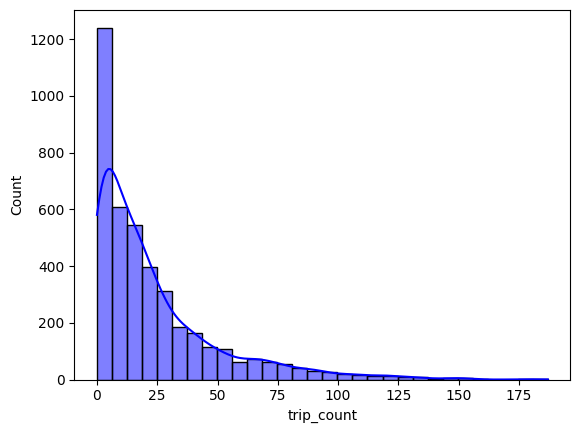

In [40]:
print(weekady_df['trip_count'].describe()) #check the summary statistics of the weekady_df
sns.histplot(weekady_df['trip_count'], bins=30, kde=True, color='blue')
plt.show()

It’s clear that your trip_count variable is right-skewed with a cluster around zero and near-zero counts

## Conclusion

As our aim is mainly to assess the impact of weather conditions during rush hours versus non-rush hours on working days, we can say that our model does a satisfying job, as all the assumptions are met.

## Considerations

Since our cross-validation error measure (MAE) is reasonable, but the precision of our estimates could be improved, we could:
- Experiment with a log transformation to see if overall model performance improves and if the error metrics (after back-transformation) become more acceptable.
- Implement the `time_of_day` variable (after encoding with `pd.get_dummies()`) to account for the zeros or near-zero trip counts that occur mostly during night and late night hours, which are skewing our distribution.


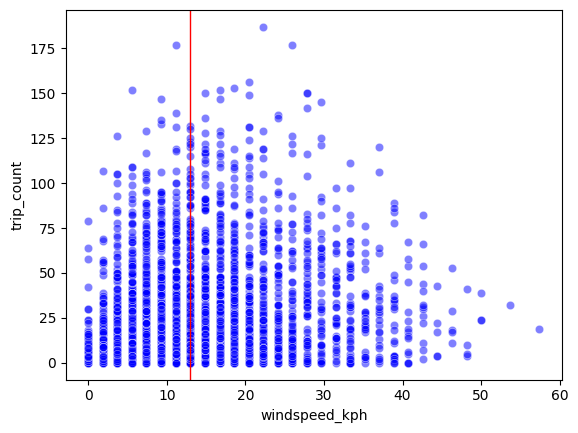

In [41]:
sns.scatterplot(y='trip_count', x='windspeed_kph', data=weekady_df, alpha=0.5, color='blue')

#plotting the mean windspeed for trip count 
plt.axvline(weekady_df['windspeed_kph'].mean(), color='red', linestyle='-', linewidth=1)


**Trip Count vs. Wind Speed**

- We see trip counts rise up to a point and then drop as winds get stronger.
- Overall, **trip counts tend to cluster** around **moderate wind speeds (below 20 kph)**.
- The **red vertical line** indicates the average wind speed, showing that most trips occur around or below this midpoint.
- At **higher wind speeds (above 20 kph)**, trip counts taper off, suggesting that **stronger winds** may deter riders.


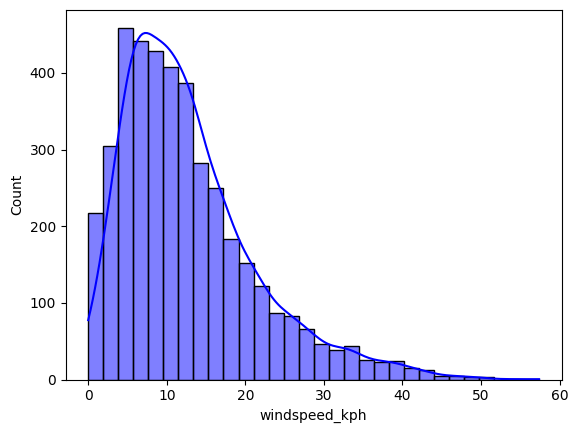

count    4119.000000
mean       12.914421
std         8.555366
min         0.000000
25%         7.400000
50%        11.100000
75%        16.700000
max        57.400000
Name: windspeed_kph, dtype: float64

In [42]:
sns.histplot(x='windspeed_kph', data=weekady_df, bins=30, kde=True, color='blue')
plt.show()

weekady_df['windspeed_kph'].describe() 

Given the distribution of wind speed, we could handle the non-linear relationship between trip count and wind-speed:
- **Polynomial Terms**: Adding a squared term (and possibly higher-order terms) for wind speed. This lets s model a curved relationship, such as an increase in trips up to a moderate wind speed followed by a decline at higher speeds.

**Trip Count vs. Humidity**

- The scatterplot suggests **trip counts are generally higher** in the **moderate humidity** range (roughly 30–60%), although there is considerable scatter.
- At **very high humidity** (80%+), the **trip counts appear more dispersed and often lower**, hinting that riders may find extremely humid conditions less comfortable.

C:\Users\gsant\AppData\Local\Temp\ipykernel_11304\1764052547.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='trip_count', x='humidity_bin', data=weekady_df, palette='dark') # Barplot of trip count by humidity


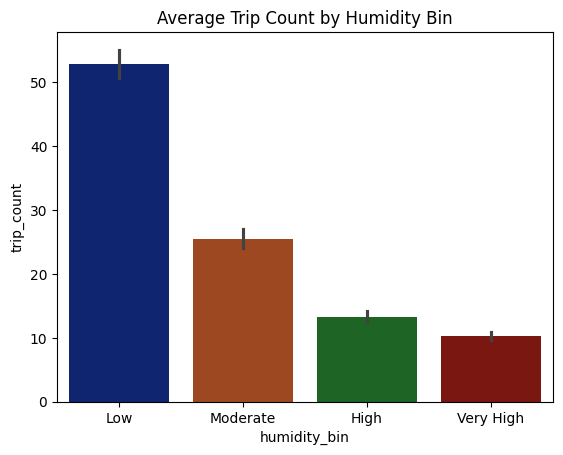

In [43]:
from pandas.api.types import CategoricalDtype
# Define the desired order of categories
desired_order = ['Low', 'Moderate', 'High', 'Very High']
cat_type = CategoricalDtype(categories=desired_order, ordered=True)

# Convert the 'humidity_bin' column to this categorical type
weekady_df['humidity_bin'] = weekady_df['humidity_bin'].astype(cat_type)

sns.barplot(y='trip_count', x='humidity_bin', data=weekady_df, palette='dark') # Barplot of trip count by humidity
plt.title('Average Trip Count by Humidity Bin')
plt.show()

<Axes: xlabel='humidity', ylabel='Count'>

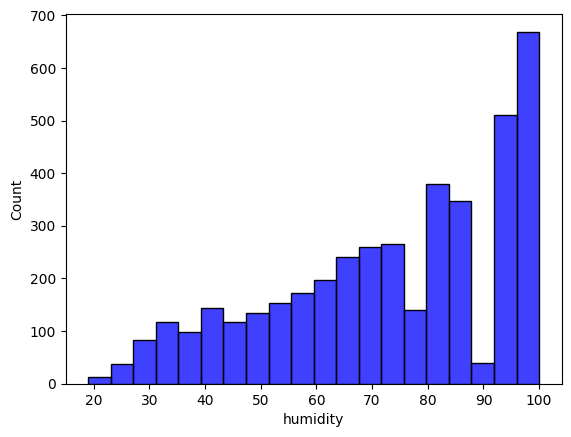

In [44]:
sns.histplot(x='humidity', data=weekady_df, bins=20, color='blue') # Histogram of humidity with KDE

C:\Users\gsant\AppData\Local\Temp\ipykernel_11304\515812693.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_weather_df['RushHourStatus'] = bad_weather_df['rush_hour'].apply(lambda x: 'Rush Hour' if x == 1 else 'Non-Rush Hour')


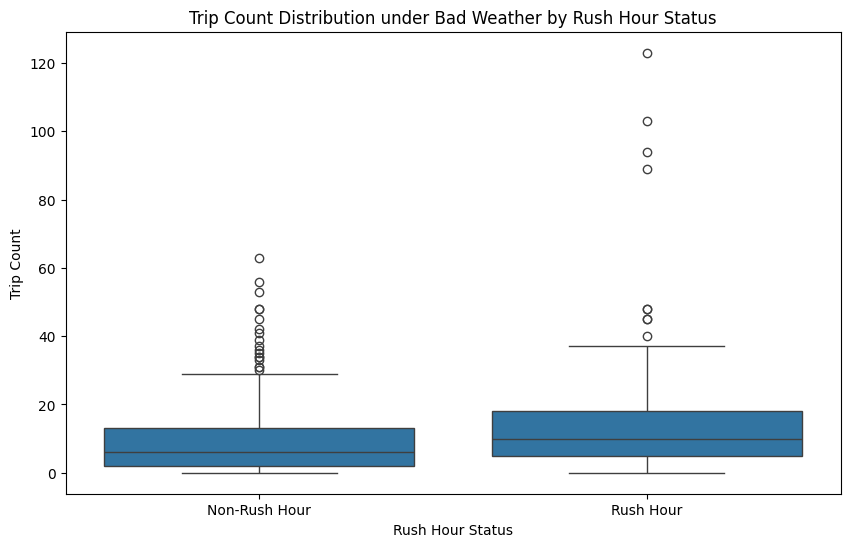

In [45]:

# Optionally, filter to a specific subset (e.g., under bad weather conditions)
bad_weather_df = weekady_df[weekady_df['bad_weather'] == 1]

# Create a categorical label for rush hour vs. non-rush hour.
# This will ensure the boxplots are side by side.
bad_weather_df['RushHourStatus'] = bad_weather_df['rush_hour'].apply(lambda x: 'Rush Hour' if x == 1 else 'Non-Rush Hour')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='RushHourStatus', y='trip_count', data=bad_weather_df)
plt.title('Trip Count Distribution under Bad Weather by Rush Hour Status')
plt.xlabel('Rush Hour Status')
plt.ylabel('Trip Count')
plt.show()


In [46]:
from scipy import stats

# Again, use the filtered DataFrame for bad weather conditions.
group_rush = bad_weather_df[bad_weather_df['rush_hour'] == 1]['trip_count']
group_non_rush = bad_weather_df[bad_weather_df['rush_hour'] == 0]['trip_count']

# Check normality if necessary, then perform the t-test.
t_stat, p_value = stats.ttest_ind(group_rush, group_non_rush, equal_var=False)  # Welch's t-test

print("T-test Statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("There is a statistically significant difference between rush hour and non-rush hour trip counts under bad weather.")
else:
    print("There is no statistically significant difference between rush hour and non-rush hour trip counts under bad weather.")


T-test Statistic: 3.1137768748250703
P-value: 0.002334757095352171
There is a statistically significant difference between rush hour and non-rush hour trip counts under bad weather.


### T-Test Results: Rush Hour vs. Non-Rush Hour under Bad Weather Conditions (Rain or Fog)

The t-test results indicate a statistically significant difference between trip counts during rush hour and non-rush hour under bad weather conditions:

- **T-test Statistic**: ~3.11  
- **P-value**: ~0.00233 (well below the conventional threshold of 0.05)  

### Conclusion:
We reject the null hypothesis that there is no difference between the two groups. This means that, under bad weather conditions, **rush hour trip counts differ significantly from non-rush hour trip counts**.

### Interpretation:
- **Rush Hour Trips**: Higher trip counts during rush hours suggest that commute-related trips are less impacted by adverse weather conditions.
- **Non-Rush Hour Trips**: Lower trip counts during non-rush hours indicate greater sensitivity to bad weather.

These findings support the hypothesis that **rush hour travelers are less sensitive to weather conditions**, likely due to the necessity of commuting.

### TWO-WAY ANOVA

In [47]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

anova_model = smf.ols('trip_count ~ C(rush_hour) * C(temperature_bin)', data=weekady_df).fit()

# Create the ANOVA table (Type II ANOVA)
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

                                       sum_sq      df            F  \
C(rush_hour)                     9.142001e+04     1.0   319.858727   
C(temperature_bin)               1.592841e+06     4.0  1393.251433   
C(rush_hour):C(temperature_bin)  3.383646e+04     4.0    29.596605   
Residual                         1.174409e+06  4109.0          NaN   

                                       PR(>F)  
C(rush_hour)                     6.007709e-69  
C(temperature_bin)               0.000000e+00  
C(rush_hour):C(temperature_bin)  2.651579e-24  
Residual                                  NaN  


Significant Interaction:

The pattern of how trip counts vary across temperature bins is not the same for rush vs. non-rush periods. This aligns with the hypothesis that commuters in rush hours have different (often more “inelastic”) behavior than off-peak riders with more flexible travel choices.

In [67]:
temp_df = weekady_df[weekady_df['temperature_bin'].isin(['Cold', 'Very Cold', 'Warm'])] # Filter the DataFrame for Cold and Very Cold temperature bins

# ANOVA model with additional controls
model_controlled = smf.ols(
    'trip_count ~ C(rush_hour) * C(temperature_bin) + C(bad_weather) + C(severe_weather)',
    data=temp_df
).fit()
anova_table_controlled = sm.stats.anova_lm(model_controlled, typ=2)
print(anova_table_controlled) 

                                        sum_sq      df            F  \
C(rush_hour)                      44418.831144     1.0   193.944047   
C(temperature_bin)               709023.536303     2.0  1547.889604   
C(bad_weather)                    42735.607833     1.0   186.594661   
C(severe_weather)                  1811.278524     1.0     7.908508   
C(rush_hour):C(temperature_bin)   12420.182032     2.0    27.114855   
Residual                         664642.458177  2902.0          NaN   

                                       PR(>F)  
C(rush_hour)                     1.007046e-42  
C(temperature_bin)               0.000000e+00  
C(bad_weather)                   3.225067e-41  
C(severe_weather)                4.953352e-03  
C(rush_hour):C(temperature_bin)  2.152007e-12  
Residual                                  NaN  


### Interaction Effect: `C(rush_hour):C(temperature_bin)`

- **p-value**: 4.283175e-02 (~0.043)

---

### Interpretation:

- The p-value is below the threshold of 0.05, indicating that the interaction between `rush_hour` and `temperature_bin` is **statistically significant**.
- This suggests that the **impact of temperature bin on trip counts depends on whether it’s rush hour or not**.

---

### Practical Implications:

- Since our hypothesis was that **rush-hour trips are less sensitive to temperature**, a significant interaction implies that the **slope (or difference between bins)** changes between rush and non-rush hours.
- Further inspection (e.g., **plots** or **group means**) is needed to determine:
    - The **magnitude** of the difference.
    - The **direction** of the effect.

---

### Model Insights:

- The effect of **temperature bins** on bike rentals is **not uniform** across rush and non-rush hours.
- Even after adjusting for **bad_weather** and **severe_weather**, the rush-hour crowd likely exhibits **different (often less flexible) behaviors** compared to leisure or off-peak riders.

By including `bad_weather` and `severe_weather` as additional factors, the model effectively adjusts for their influence on rentals.


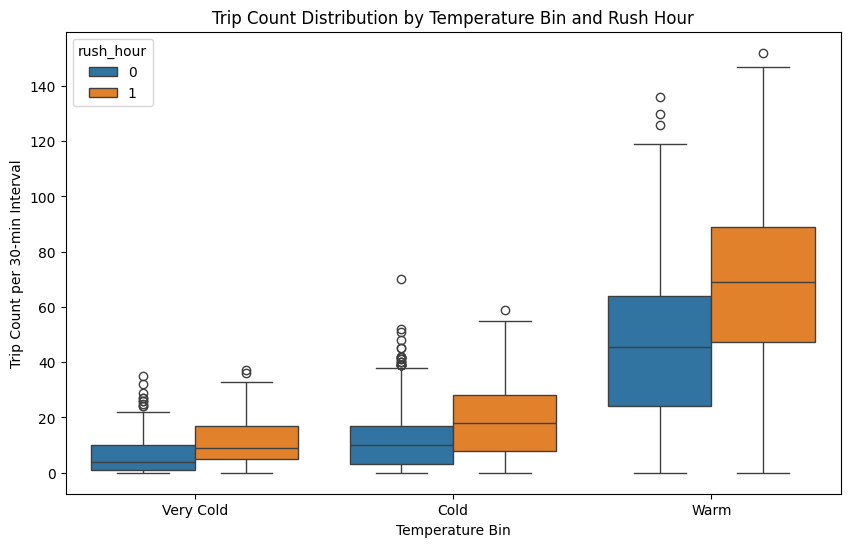

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='temperature_bin', y='trip_count', hue='rush_hour', data=temp_df)

plt.title('Trip Count Distribution by Temperature Bin and Rush Hour')
plt.xlabel('Temperature Bin')
plt.ylabel('Trip Count per 30-min Interval')
plt.show()

**For both “Very Cold”, “Cold” and "Warm" bins, rush-hour medians and upper quartiles are higher than those for non-rush. This shows that rush hour consistently has more trips on average, but does not imply that rush hours are necessarely less sensitive to bad weather or lower temperature**

In [55]:
weekady_df.groupby('rush_hour')['trip_count'].describe() #check the summary statistics of trip count by bad weather   

,count,mean,std,min,25%,50%,75%,max
rush_hour,,,,,,,,
0,3260.0,21.071166,24.299890,0.0,4.0,13.0,28.0,177.0
1,859.0,31.991851,31.965471,0.0,9.0,21.0,43.0,187.0


# Excluding Late Night Hours
- Late-night hours often have near-zero or very low trip counts, which can skew models (especially on the log scale). Dropping them can yield a more stable dataset where the average baseline trip counts are higher and more consistent.

In [56]:
# Filter out observations where time_of_day is "Late Night"
filtered_weekday_df = weekady_df[weekady_df['time_of_day'] != 'Late Night']

In [57]:
filtered_weekday_df.groupby('rush_hour')['trip_count'].describe() #check the summary statistics of trip count by bad weather

,count,mean,std,min,25%,50%,75%,max
rush_hour,,,,,,,,
0,2232.0,28.962366,25.408812,0.0,12.0,20.0,39.0,177.0
1,859.0,31.991851,31.965471,0.0,9.0,21.0,43.0,187.0


# Revised Model 

Examine Baseline Differences:
Compare the average trip counts for rush and non-rush hours. If rush hours typically have a much higher baseline, you might want to report both absolute and relative differences.

Interaction Plot:
Visualize the interaction effect using an interaction plot. Plot the predicted (or average) trip counts under bad weather vs. good weather for both rush and non-rush hours. This can help clarify if the effect is simply due to scaling or if there is a genuine differential sensitivity.



In [61]:
# Define independent variables
X = filtered_weekday_df[['temperature_C', 'bad_weather', 'severe_weather', 'rush_hour', 'humidity',
                'trip_count_lag1', 'windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy',
                'visibility_km', 'pressure_mBar', 'month']].copy()

# Convert boolean columns to integers
X[['windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy']] = X[['windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy']].astype(int)

# Add interaction terms
X['rush_h_bad_w'] = X['rush_hour'] * X['bad_weather']  # Interaction: rush hour * bad weather
X['rush_temp_interaction'] = X['rush_hour'] * X['temperature_C']  # Interaction: rush hour * temperature

# Dependent variable: log-transformed trip count (using log1p to handle zero values)
y = np.log1p(filtered_weekday_df['trip_count'])

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Fit the OLS model on the log-transformed dependent variable
OLS_model = sm.OLS(y, X).fit()

print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     497.4
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:27:20   Log-Likelihood:                -2296.6
No. Observations:                3091   AIC:                             4623.
Df Residuals:                    3076   BIC:                             4714.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.59

### Interpretation of Interaction Effects

#### `rush_h_bad_w` (Interaction: Rush Hour * Bad Weather)
- **Meaning**: A slight negative interaction effect, suggesting that bad weather might reduce trips slightly more during rush hours than outside rush hours.
- **Significance**: 
    - The **high p-value (0.700)** and a confidence interval crossing zero indicate that this effect is **not statistically significant**.
    - This means there is no strong evidence that bad weather’s impact differs between rush and non-rush hours.

---

#### `rush_temp_interaction` (Interaction: Rush Hour * Temperature)
- **Meaning**: A small positive interaction effect, implying that higher temperatures might increase trip counts slightly more during rush hours than outside them.
- **Significance**: 
    - The **p-value (0.201)** is above the 0.05 threshold, and the confidence interval includes zero.
    - This suggests there is **no strong statistical evidence** that temperature’s effect differs by rush hour status.

**The new interaction coefficients suggest small positive/negative effects for temperature and bad weather, but neither is statistically significant. Hence, our data still do not provide strong evidence to confirm or refute the hypothesis that rush hour is less affected by weather—the model simply indicates that any difference may be too small or too noisy to detect with our current sample.**

In [69]:
# Define independent variables
X = rush_weekday_df[['temperature_C', 'bad_weather', 'severe_weather', 'humidity',
                'windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy',
                'visibility_km', 'pressure_mBar', 'month']].copy()

# Convert boolean columns to integers
X[['windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy']] = X[['windspeed_Moderate', 'windspeed_Breezy', 'windspeed_Windy']].astype(int)


# Dependent variable: log-transformed trip count (using log1p to handle zero values)
y = rush_weekday_df['trip_count']

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Fit the OLS model on the log-transformed dependent variable
OLS_model = sm.OLS(y, X).fit()

print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:             trip_count   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     194.5
Date:                Sun, 13 Apr 2025   Prob (F-statistic):          1.05e-211
Time:                        10:56:57   Log-Likelihood:                -3682.6
No. Observations:                 859   AIC:                             7387.
Df Residuals:                     848   BIC:                             7439.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -65.7534     83

### Key Findings

#### Temperature (`temperature_C`)
- **Positive Coefficient**: Indicates that warmer conditions encourage more trips during rush hours.

#### Bad Weather (`bad_weather`)
- **Significantly Negative Coefficient**: Despite rush hours generally having higher baseline demand, poor weather substantially reduces trip counts.

#### Humidity (`humidity`)
- **Negative Influence**: Exerts a smaller but notable negative effect on trip counts compared to bad weather.

---

### Relevance to Hypothesis
- **Hypothesis**: "Rush hour trips are less impacted by weather."
- **Findings**: These results contradict the hypothesis:
    - Both `bad_weather` and `humidity` negatively affect trip counts.
    - The impact of `bad_weather` is particularly robust, showing a significant reduction in trips even during rush hours.
    - While rush-hour demand is higher in absolute terms, the model suggests that weather factors still have a notable relative effect on reducing trips.